In [0]:
# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


# Imports

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Model, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, AveragePooling2D, Activation, Lambda, Add
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.datasets import cifar10
from keras.utils import to_categorical
import keras.backend as K

from utils import plot_accuracy_and_loss, plot_confusion_matrix, plot_smoothed_acc_and_loss, extract_features
from oct_conv2d import OctConv2D

Using TensorFlow backend.


# Parameters

In [2]:
STD_SIZE = (32, 32)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# Data preparation

In [12]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

x_train = x_train / 255
x_test = x_test / 255
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(
    x=x_train,
    y=y_train,
    batch_size=BATCH_SIZE)

test_generator = test_datagen.flow(
    x=x_test,
    y=y_test,
    batch_size=BATCH_SIZE)

# Baseline

## Model

In [11]:
inputs = Input(shape=(32, 32, 3))
conv = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(64, (3, 3), activation='relu', padding='same')(pool)
conv = Conv2D(64, (3, 3), activation='relu', padding='same')(conv)
pool = MaxPooling2D(pool_size=(2, 2))(conv)
conv = Conv2D(128, (3, 3), activation='relu', padding='same')(pool)
conv = Conv2D(128, (3, 3), activation='relu', padding='same')(conv)
pool = MaxPooling2D(pool_size=(2, 2))(conv)

flat = Flatten()(pool)
outputs = Dense(512, activation='relu')(flat)
outputs = Dense(10, activation='softmax')(outputs)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['accuracy'])

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 128)         73856     
__________

In [13]:
history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + '7_layers_cifar_alpha_0', monitor='val_acc', save_best_only=True, verbose=1)
              ])

with open(PATH + '7_layers_cifar_alpha_0_history', 'wb') as f:
    pickle.dump(history.history, f)

Epoch 1/100
 - 39s - loss: 1.8495 - acc: 0.3252 - val_loss: 1.6215 - val_acc: 0.4224

Epoch 00001: val_acc improved from -inf to 0.42240, saving model to 7_layers_cifar_alpha_0
Epoch 2/100
 - 38s - loss: 1.6077 - acc: 0.4183 - val_loss: 1.5493 - val_acc: 0.4514

Epoch 00002: val_acc improved from 0.42240 to 0.45140, saving model to 7_layers_cifar_alpha_0
Epoch 3/100
 - 38s - loss: 1.4846 - acc: 0.4656 - val_loss: 1.3238 - val_acc: 0.5208

Epoch 00003: val_acc improved from 0.45140 to 0.52080, saving model to 7_layers_cifar_alpha_0
Epoch 4/100
 - 38s - loss: 1.4006 - acc: 0.5003 - val_loss: 1.2793 - val_acc: 0.5442

Epoch 00004: val_acc improved from 0.52080 to 0.54420, saving model to 7_layers_cifar_alpha_0
Epoch 5/100
 - 38s - loss: 1.3308 - acc: 0.5230 - val_loss: 1.1557 - val_acc: 0.5885

Epoch 00005: val_acc improved from 0.54420 to 0.58850, saving model to 7_layers_cifar_alpha_0
Epoch 6/100
 - 38s - loss: 1.2773 - acc: 0.5453 - val_loss: 1.1090 - val_acc: 0.6019

Epoch 00006: val_

 - 38s - loss: 0.8805 - acc: 0.7027 - val_loss: 0.7624 - val_acc: 0.7504

Epoch 00054: val_acc did not improve from 0.77400
Epoch 55/100
 - 38s - loss: 0.8835 - acc: 0.7028 - val_loss: 0.8345 - val_acc: 0.7285

Epoch 00055: val_acc did not improve from 0.77400
Epoch 56/100
 - 37s - loss: 0.8835 - acc: 0.7021 - val_loss: 0.7930 - val_acc: 0.7360

Epoch 00056: val_acc did not improve from 0.77400
Epoch 57/100
 - 37s - loss: 0.8843 - acc: 0.7046 - val_loss: 1.2020 - val_acc: 0.6800

Epoch 00057: val_acc did not improve from 0.77400
Epoch 58/100
 - 38s - loss: 0.8912 - acc: 0.6992 - val_loss: 0.8374 - val_acc: 0.7379

Epoch 00058: val_acc did not improve from 0.77400
Epoch 59/100
 - 38s - loss: 0.8833 - acc: 0.7027 - val_loss: 0.7447 - val_acc: 0.7579

Epoch 00059: val_acc did not improve from 0.77400
Epoch 60/100
 - 37s - loss: 0.8924 - acc: 0.6987 - val_loss: 0.7353 - val_acc: 0.7594

Epoch 00060: val_acc did not improve from 0.77400
Epoch 61/100
 - 38s - loss: 0.8921 - acc: 0.6974 - val

## Results

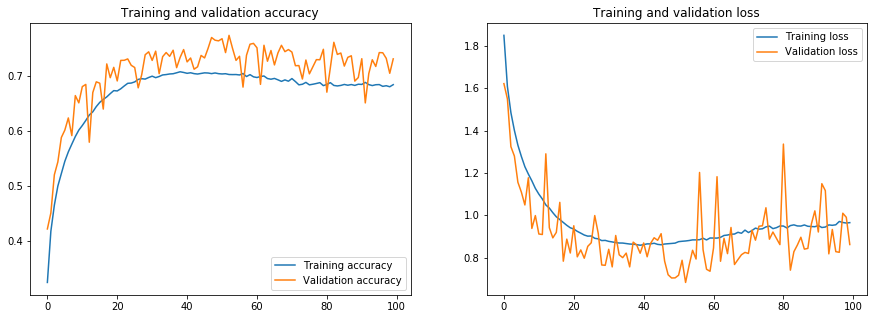

In [14]:
plot_accuracy_and_loss(history)

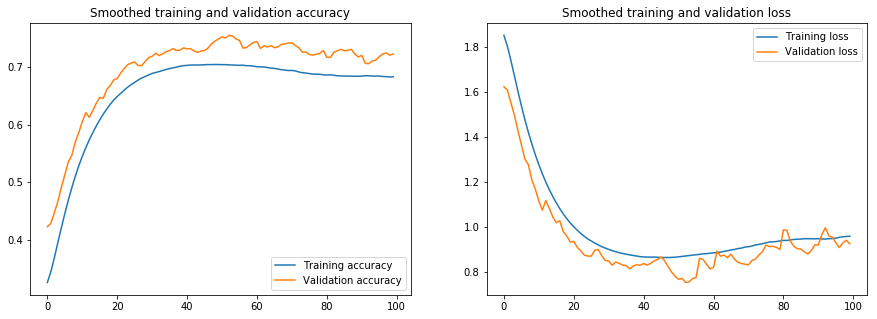

In [15]:
plot_smoothed_acc_and_loss(history, 0.8)

In [16]:
model = load_model(PATH + '7_layers_cifar_alpha_0')
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 216us/step


[0.6877797739982605, 0.7735]

# OctConv

In [17]:
for alpha in [0.125, 0.25, 0.5, 0.75]:
    inputs = Input(shape=(32, 32, 3))
    low = AveragePooling2D(2)(inputs)
    
    high, low = OctConv2D(filters=32, alpha=alpha)([inputs, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=64, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    high, low = OctConv2D(filters=64, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)
    
    high, low = MaxPooling2D(2)(high), MaxPooling2D(2)(low)
    
    high, low = OctConv2D(filters=128, alpha=alpha)([high, low])
    high, low = Activation('relu')(high), Activation('relu')(low)

    high = Conv2D(128, 3, padding='same')(high)
    low = Conv2D(128, 3, padding='same')(low)
    low = Lambda(lambda x: K.repeat_elements(K.repeat_elements(x, 2, axis=1), 2, axis=2))(low)
    x = Add()([high, low])
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    flat = Flatten()(x)
    outputs = Dense(512, activation='relu')(flat)
    outputs = Dense(10, activation='softmax')(outputs)
    model = Model(inputs=inputs, outputs=outputs)

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(lr=1e-4),
                  metrics=['accuracy'])
    history = model.fit_generator(
    train_generator, 
    steps_per_epoch=train_generator.n // BATCH_SIZE, epochs=100, verbose=2,
    validation_data=test_generator, validation_steps=test_generator.n // BATCH_SIZE, 
    callbacks=[History(),
               ModelCheckpoint(PATH + f'7_layers_cifar_alpha_{alpha}', monitor='val_acc', save_best_only=True, verbose=1)
              ])

    with open(PATH + f'7_layers_cifar_alpha_{alpha}_history', 'wb') as f:
        pickle.dump(history.history, f)

Epoch 1/100
 - 68s - loss: 1.8420 - acc: 0.3284 - val_loss: 1.5215 - val_acc: 0.4413

Epoch 00001: val_acc improved from -inf to 0.44130, saving model to 7_layers_cifar_alpha_0.125
Epoch 2/100
 - 66s - loss: 1.6252 - acc: 0.4120 - val_loss: 1.4597 - val_acc: 0.4688

Epoch 00002: val_acc improved from 0.44130 to 0.46880, saving model to 7_layers_cifar_alpha_0.125
Epoch 3/100
 - 66s - loss: 1.5166 - acc: 0.4539 - val_loss: 1.3501 - val_acc: 0.5179

Epoch 00003: val_acc improved from 0.46880 to 0.51790, saving model to 7_layers_cifar_alpha_0.125
Epoch 4/100
 - 66s - loss: 1.4340 - acc: 0.4843 - val_loss: 1.2159 - val_acc: 0.5655

Epoch 00004: val_acc improved from 0.51790 to 0.56550, saving model to 7_layers_cifar_alpha_0.125
Epoch 5/100
 - 66s - loss: 1.3697 - acc: 0.5107 - val_loss: 1.4387 - val_acc: 0.5120

Epoch 00005: val_acc did not improve from 0.56550
Epoch 6/100
 - 66s - loss: 1.3225 - acc: 0.5264 - val_loss: 1.1611 - val_acc: 0.5937

Epoch 00006: val_acc improved from 0.56550 to


Epoch 00054: val_acc did not improve from 0.74820
Epoch 55/100
 - 66s - loss: 0.9197 - acc: 0.6855 - val_loss: 1.1649 - val_acc: 0.6744

Epoch 00055: val_acc did not improve from 0.74820
Epoch 56/100
 - 66s - loss: 0.9271 - acc: 0.6849 - val_loss: 1.0094 - val_acc: 0.6667

Epoch 00056: val_acc did not improve from 0.74820
Epoch 57/100
 - 66s - loss: 0.9256 - acc: 0.6863 - val_loss: 0.7472 - val_acc: 0.7469

Epoch 00057: val_acc did not improve from 0.74820
Epoch 58/100
 - 66s - loss: 0.9236 - acc: 0.6856 - val_loss: 1.1499 - val_acc: 0.6825

Epoch 00058: val_acc did not improve from 0.74820
Epoch 59/100
 - 66s - loss: 0.9301 - acc: 0.6845 - val_loss: 0.8754 - val_acc: 0.7215

Epoch 00059: val_acc did not improve from 0.74820
Epoch 60/100
 - 66s - loss: 0.9358 - acc: 0.6830 - val_loss: 0.7990 - val_acc: 0.7478

Epoch 00060: val_acc did not improve from 0.74820
Epoch 61/100
 - 66s - loss: 0.9408 - acc: 0.6818 - val_loss: 0.8279 - val_acc: 0.7320

Epoch 00061: val_acc did not improve fro

 - 66s - loss: 1.1976 - acc: 0.5743 - val_loss: 1.1835 - val_acc: 0.5932

Epoch 00011: val_acc did not improve from 0.61830
Epoch 12/100
 - 66s - loss: 1.1727 - acc: 0.5846 - val_loss: 1.0189 - val_acc: 0.6397

Epoch 00012: val_acc improved from 0.61830 to 0.63970, saving model to 7_layers_cifar_alpha_0.25
Epoch 13/100
 - 66s - loss: 1.1562 - acc: 0.5911 - val_loss: 1.0623 - val_acc: 0.6266

Epoch 00013: val_acc did not improve from 0.63970
Epoch 14/100
 - 66s - loss: 1.1349 - acc: 0.5975 - val_loss: 1.0348 - val_acc: 0.6378

Epoch 00014: val_acc did not improve from 0.63970
Epoch 15/100
 - 66s - loss: 1.1259 - acc: 0.6031 - val_loss: 1.0492 - val_acc: 0.6371

Epoch 00015: val_acc did not improve from 0.63970
Epoch 16/100
 - 66s - loss: 1.1162 - acc: 0.6088 - val_loss: 0.9400 - val_acc: 0.6736

Epoch 00016: val_acc improved from 0.63970 to 0.67360, saving model to 7_layers_cifar_alpha_0.25
Epoch 17/100
 - 66s - loss: 1.0986 - acc: 0.6148 - val_loss: 0.9601 - val_acc: 0.6674

Epoch 0001


Epoch 00067: val_acc did not improve from 0.72630
Epoch 68/100
 - 66s - loss: 0.9750 - acc: 0.6705 - val_loss: 0.9469 - val_acc: 0.7037

Epoch 00068: val_acc did not improve from 0.72630
Epoch 69/100
 - 66s - loss: 0.9668 - acc: 0.6757 - val_loss: 0.9101 - val_acc: 0.7198

Epoch 00069: val_acc did not improve from 0.72630
Epoch 70/100
 - 66s - loss: 0.9791 - acc: 0.6701 - val_loss: 0.8452 - val_acc: 0.7372

Epoch 00070: val_acc improved from 0.72630 to 0.73720, saving model to 7_layers_cifar_alpha_0.25
Epoch 71/100
 - 66s - loss: 0.9788 - acc: 0.6722 - val_loss: 0.8759 - val_acc: 0.7326

Epoch 00071: val_acc did not improve from 0.73720
Epoch 72/100
 - 66s - loss: 0.9799 - acc: 0.6688 - val_loss: 0.8695 - val_acc: 0.7186

Epoch 00072: val_acc did not improve from 0.73720
Epoch 73/100
 - 66s - loss: 0.9749 - acc: 0.6717 - val_loss: 0.9241 - val_acc: 0.7165

Epoch 00073: val_acc did not improve from 0.73720
Epoch 74/100
 - 66s - loss: 0.9719 - acc: 0.6724 - val_loss: 1.1508 - val_acc: 0


Epoch 00023: val_acc did not improve from 0.67170
Epoch 24/100
 - 65s - loss: 1.0839 - acc: 0.6220 - val_loss: 0.9379 - val_acc: 0.6747

Epoch 00024: val_acc improved from 0.67170 to 0.67470, saving model to 7_layers_cifar_alpha_0.5
Epoch 25/100
 - 65s - loss: 1.0826 - acc: 0.6235 - val_loss: 0.9598 - val_acc: 0.6726

Epoch 00025: val_acc did not improve from 0.67470
Epoch 26/100
 - 65s - loss: 1.0827 - acc: 0.6224 - val_loss: 0.9542 - val_acc: 0.6821

Epoch 00026: val_acc improved from 0.67470 to 0.68210, saving model to 7_layers_cifar_alpha_0.5
Epoch 27/100
 - 65s - loss: 1.0678 - acc: 0.6279 - val_loss: 0.9580 - val_acc: 0.6677

Epoch 00027: val_acc did not improve from 0.68210
Epoch 28/100
 - 65s - loss: 1.0747 - acc: 0.6257 - val_loss: 0.9554 - val_acc: 0.6746

Epoch 00028: val_acc did not improve from 0.68210
Epoch 29/100
 - 65s - loss: 1.0674 - acc: 0.6270 - val_loss: 0.9431 - val_acc: 0.6827

Epoch 00029: val_acc improved from 0.68210 to 0.68270, saving model to 7_layers_cifar

 - 66s - loss: 1.0244 - acc: 0.6566 - val_loss: 0.9881 - val_acc: 0.6858

Epoch 00080: val_acc did not improve from 0.72800
Epoch 81/100
 - 66s - loss: 1.0238 - acc: 0.6548 - val_loss: 0.9689 - val_acc: 0.6780

Epoch 00081: val_acc did not improve from 0.72800
Epoch 82/100
 - 66s - loss: 1.0178 - acc: 0.6571 - val_loss: 1.0192 - val_acc: 0.6804

Epoch 00082: val_acc did not improve from 0.72800
Epoch 83/100
 - 66s - loss: 1.0189 - acc: 0.6563 - val_loss: 1.0786 - val_acc: 0.6434

Epoch 00083: val_acc did not improve from 0.72800
Epoch 84/100
 - 65s - loss: 1.0190 - acc: 0.6567 - val_loss: 1.0289 - val_acc: 0.6797

Epoch 00084: val_acc did not improve from 0.72800
Epoch 85/100
 - 65s - loss: 1.0133 - acc: 0.6584 - val_loss: 0.9189 - val_acc: 0.7133

Epoch 00085: val_acc did not improve from 0.72800
Epoch 86/100
 - 65s - loss: 1.0052 - acc: 0.6601 - val_loss: 1.0361 - val_acc: 0.6903

Epoch 00086: val_acc did not improve from 0.72800
Epoch 87/100
 - 65s - loss: 1.0106 - acc: 0.6577 - val


Epoch 00034: val_acc did not improve from 0.68530
Epoch 35/100
 - 66s - loss: 1.0761 - acc: 0.6255 - val_loss: 0.9011 - val_acc: 0.6885

Epoch 00035: val_acc improved from 0.68530 to 0.68850, saving model to 7_layers_cifar_alpha_0.75
Epoch 36/100
 - 66s - loss: 1.0741 - acc: 0.6275 - val_loss: 0.8861 - val_acc: 0.6909

Epoch 00036: val_acc improved from 0.68850 to 0.69090, saving model to 7_layers_cifar_alpha_0.75
Epoch 37/100
 - 67s - loss: 1.0721 - acc: 0.6297 - val_loss: 0.9476 - val_acc: 0.6762

Epoch 00037: val_acc did not improve from 0.69090
Epoch 38/100
 - 66s - loss: 1.0715 - acc: 0.6292 - val_loss: 0.9937 - val_acc: 0.6860

Epoch 00038: val_acc did not improve from 0.69090
Epoch 39/100
 - 65s - loss: 1.0746 - acc: 0.6257 - val_loss: 1.0771 - val_acc: 0.6554

Epoch 00039: val_acc did not improve from 0.69090
Epoch 40/100
 - 65s - loss: 1.0716 - acc: 0.6281 - val_loss: 0.9622 - val_acc: 0.6742

Epoch 00040: val_acc did not improve from 0.69090
Epoch 41/100
 - 65s - loss: 1.070

 - 65s - loss: 1.0729 - acc: 0.6376 - val_loss: 0.9942 - val_acc: 0.6713

Epoch 00093: val_acc did not improve from 0.70280
Epoch 94/100
 - 65s - loss: 1.0674 - acc: 0.6374 - val_loss: 1.1554 - val_acc: 0.6613

Epoch 00094: val_acc did not improve from 0.70280
Epoch 95/100
 - 65s - loss: 1.0607 - acc: 0.6419 - val_loss: 1.0296 - val_acc: 0.6676

Epoch 00095: val_acc did not improve from 0.70280
Epoch 96/100
 - 65s - loss: 1.0710 - acc: 0.6396 - val_loss: 1.0991 - val_acc: 0.6583

Epoch 00096: val_acc did not improve from 0.70280
Epoch 97/100
 - 65s - loss: 1.0812 - acc: 0.6372 - val_loss: 0.9026 - val_acc: 0.7038

Epoch 00097: val_acc improved from 0.70280 to 0.70380, saving model to 7_layers_cifar_alpha_0.75
Epoch 98/100
 - 65s - loss: 1.0702 - acc: 0.6408 - val_loss: 0.9804 - val_acc: 0.6765

Epoch 00098: val_acc did not improve from 0.70380
Epoch 99/100
 - 65s - loss: 1.0726 - acc: 0.6416 - val_loss: 0.8748 - val_acc: 0.7075

Epoch 00099: val_acc improved from 0.70380 to 0.70750, sa

For alpha = 0:
 Max test accuracy = 0.774



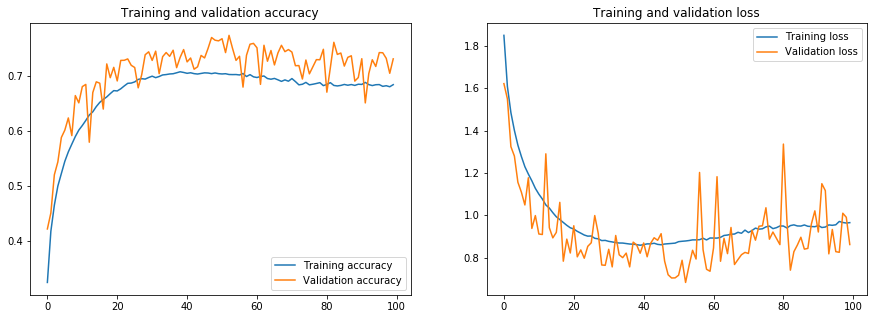

For alpha = 0.125:
 Max test accuracy = 0.7573



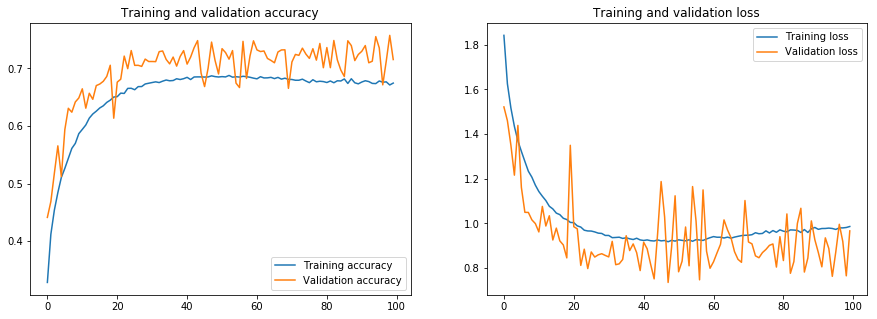

For alpha = 0.25:
 Max test accuracy = 0.7472



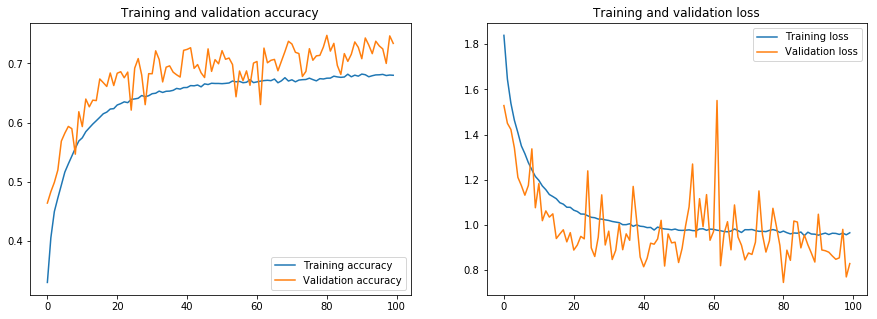

For alpha = 0.5:
 Max test accuracy = 0.7288



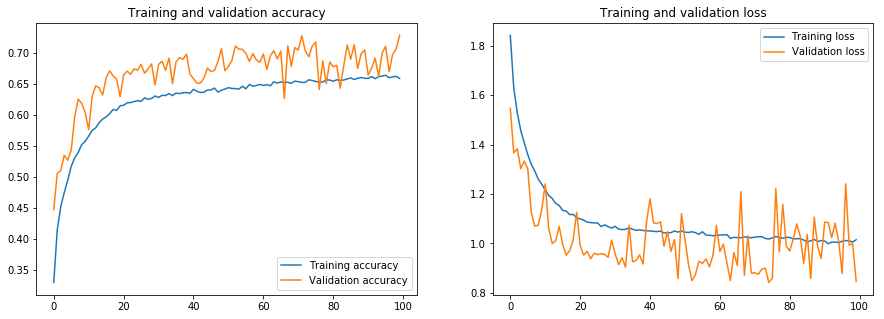

For alpha = 0.75:
 Max test accuracy = 0.7075



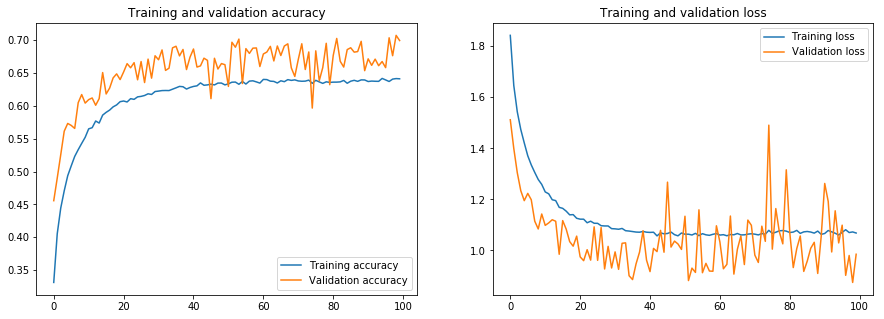

In [4]:
for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'7_layers_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        print(f"For alpha = {alpha}:\n Max test accuracy = {max(history['val_acc']):.04}\n")

    plot_accuracy_and_loss(history)

In [5]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

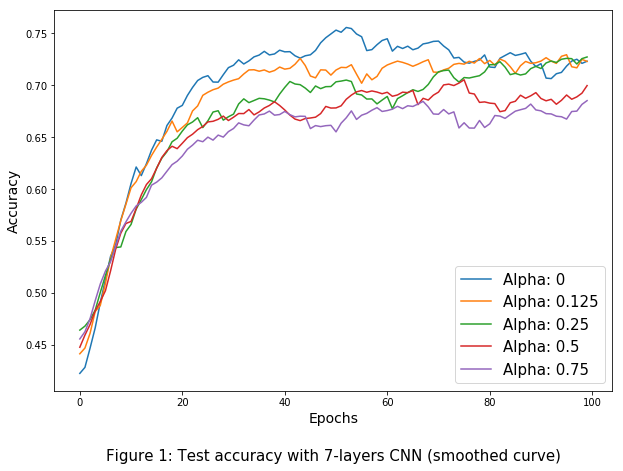

In [21]:
fig, ax = plt.subplots(figsize=(10, 7))

for alpha in [0, 0.125, 0.25, 0.5, 0.75]:
    with open(PATH + f'7_layers_cifar_alpha_{alpha}_history', 'rb') as f:
        history = pickle.load(f)
        ax.plot(smooth_curve(history['val_acc']), label=f"Alpha: {alpha}", )

ax.set_xlabel('Epochs', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title("Figure 1: Test accuracy with 7-layers CNN (smoothed curve)", size=15, y=-.2)
ax.legend(prop={'size': 15})

plt.show()